In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../src/"))
from reader import *
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tools import PDFs
import matplotlib.pyplot as plt
import lhapdf
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
#plt.rc('text', usetex=True)
#plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [2]:
labelDict = {106: "BCDMS89 D", 5160 : "NMC97 D", 5156 : "Hermes $^3$He/D", 5124 : "NMC95 $^4$He/D", 5141 : "SLACE139 $^4$He/D", 
            5115 : "NMC95 Li/D", 5138 : "SLACE139 Be/D", 5125 : "FNAL-E665 C/D", 5139 : "SLACE139 C/D", 5107 : "EMC88 C/D", 
            5110 : "EMC90 C/D", 5113 : "NMC95 C/D", 5114 : "NMC95 C/D", 5157 : "Hermes N/D", 5103 : "BCDMS85 N/D", 5134 : "SLACE49 Al/D", 
            5136 : "SLACE139 Al/D", 5121 : "NMC95 Ca/D", 5126 : "FNALE665 Ca/D", 5140 : "SLACE139 Ca/D", 5109 : "EMC90 Ca/D", 
            5131 : "SLACE49 Fe/D", 5132 : "SLACE139 Fe/D", 5133 : "SLACE140 Fe/D", 5101 : "BCDMS87 Fe/D", 5102 : "BCDMS85 Fe/D", 
            5104 : "EMC93 Cu/D", 5105 : "EMC93 Cu/D", 5106 : "EMC88 Cu/D", 5158 : "Hermes Kr/D", 5135 : "SLACE139 Ag/D", 
            5108 : "EMC88 Sn/D", 5127 : "FNALE665 Xe/D", 5137 : "SLACE139 Au/D", 5129 : "FNALE665 Pb/D", 
            9976 : "CLAS Pb/D", 9977 : "CLAS Fe/D", 9978 : "CLAS Al/D", 9979 : "CLAS C/D", 9980 : "Hall-C $^4$He/D", 9981 : "Hall-C $^4$He/D", 
            9982 : "Hall-C $^3$He/D", 9983 : "Hall-C $^3$He/D", 9984 : "Hall-C Cu/D", 9985 : "Hall-C Cu/D", 9986 : "Hall-C Be/D", 
            9987 : "Hall-C Be/D", 9988 : "Hall-C Au/D", 9989 : "Hall-C Au/D", 9990 : "Hall-C C/D", 9991 : "Hall-C C/D", 9992 : "Hall-C C/D", 
            9993 : "Hall-C C/D", 9994 : "Hall-C C/D", 9995 : "Hall-C C/D", 9996 : "Hall-C C/D", 9997 : "Hall-C C/D", 9998 : "Hall-C C/D",
            9999 : "Hall-C C/D", 5123 : "NMC95 C/Li", 5122 : "NMC95 Ca/Li", 5112 : "NMC96 Be/C", 5111 : "NMC96 Al/C", 5120 : "NMC96 Ca/C", 
            5119 : "NMC96 Ca/C", 5143 : "NMC96 Fe/C", 5159 : "NMC96 Sn/C", 5116 : "NMC96 Pb/C", 5203 : "FNALE772 C/D", 5204 : "FNALE772 Ca/D", 
            5205 : "FNALE772 Fe/D", 5206 : "FNALE772 W/D", 5201 : "FNALE886 Fe/Be", 5202 : "FNALE886 W/Be", 791 : r"CCFR $\nu$-Fe", 792 : r"CCFR $\bar{\nu}$-Fe", 
            793 : r"NuTeV $\nu$-Fe", 794 : r"NuTeV $\bar{\nu}$-Fe", 5946 : r"Chorus $\nu$-Pb", 5947 : r"Chorus $\bar{\nu}$-Pb", 11002 : "CMS pPb/pp", 
            6211 : "ATLAS $W^-$ pPb", 6213 : "ATLAS $W^+$ pPb", 6215 : "ATLAS $Z$ pPb", 6231 : "CMS-RunI $W^-$ pPb", 6233 : "CMS-RunI $W^+$ pPb", 
            6235 : "CMS-RunI $Z$ pPb", 6232 : "CMS-RunII $W^-$ pPb", 6234 : "CMS-RunII $W^+$ pPb" , 6251 : "ALICE $W^-$ pPb", 6253 : "ALICE $W^+$ pPb",
            6275 : "LHCb $Z$ pPb"}

# Get a nice bar plot


In [9]:
#dt = DataSets("fit_CJ.yaml")
#fitname ="BaseCJ-Amode1"

#dt = DataSets("fit_CTEQ.yaml")
#fitname ="BaseCTEQ"

#dt = DataSets("fit_BaseCJA2.yaml")
#fitname ="BaseCJ"

#dt = DataSets("fit_BaseDeuCJA2.yaml")
#fitname ="BaseDeuCJ"

dt = DataSets("fit_BaseDeuDijetA2.yaml")
fitname ="BaseDeuCJDijet"

Chi2 total :  3270.966385332841
Chi2 w/o penalty :  3229.4028038297815


<Figure size 1440x288 with 0 Axes>

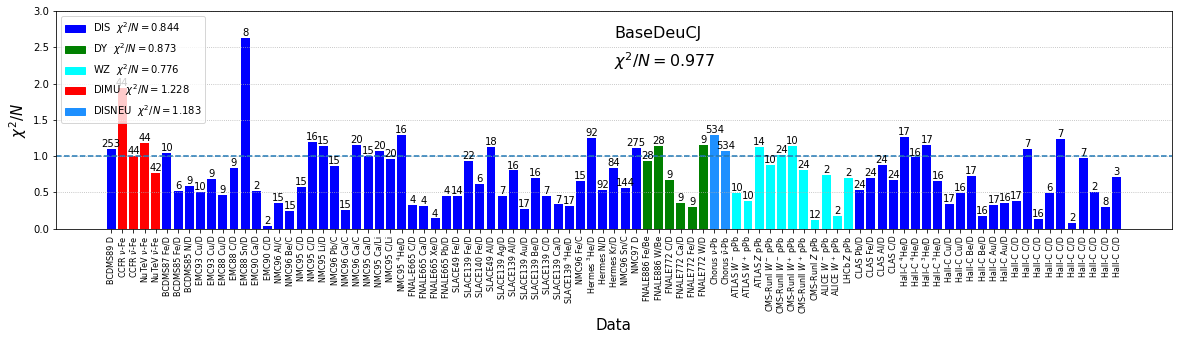

In [8]:
idList = dt.IDlist
idList.sort()
index = np.arange(len(idList))
chi2dof_perid =[]
N_perid = []
colors = []
for id in idList : 
    d = dt.datasets[id] 
    chi2dof_perid.append(d.chi2dof)
    N_perid.append(d.N)
    if id in [791, 792, 793, 794]:
        colors.append("red") #DIMU
    elif id <= 4999 and id >=4000 :
        colors.append("yellow")#SIH
    elif (id <5200 and id >=5000) or (id <=10000  and id>=9900) or id<150 :
        colors.append("blue")#DIS
    elif id <5300 and id >=5200 :
        colors.append("green")#DY
    elif id <5999 and id>=5900 :
        colors.append("dodgerblue")#DISNEU
    elif id>=6000 and id<7000 :
        colors.append("cyan")#WZ
    elif id >=11000 : 
        colors.append("orange") #dijet
    else : 
        pass


idlabel = []
for id in idList : 
    idlabel.append(labelDict[id])

#print(idlabel)
labelColors = ["blue","green", "cyan", "red",  "dodgerblue"]
#labelColors = ["blue","green", "yellow", "cyan"]
labels = ["DIS  $\chi^2/N = $" +str(round( dt.filterByExp("DIS")[3], 3)),
            "DY  $\chi^2/N = $"+str(round(dt.filterByExp("DY")[3],3)), 
            #"SIH " +str(round(dt.filterByExp("SIH")[3], 3)),
            "WZ  $\chi^2/N = $" +str(round(dt.filterByExp("WZPROD")[3], 3)),
             "DIMU  $\chi^2/N = $" +str(round(dt.filterByExp("DISDIMU")[3], 3)),
             "DISNEU  $\chi^2/N = $"+str(round(dt.filterByExp("DISNEU")[3], 3)),
            ]

        
handles = [plt.Rectangle((0,0),1,1, color=labelColors[i]) for i in range(len(labelColors))]
plt.figure(figsize=(20,4))
fig, ax = plt.subplots(figsize=(20,4))
ax.axhline(1.0, linestyle="dashed")
barPlot = ax.bar(index, chi2dof_perid, color = colors)

for num, rect in zip(N_perid, barPlot):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, num, ha='center', va='bottom',  fontsize=10)
    
# add information on fitname
plt.gca().text(0.5, 0.93, fitname , transform=plt.gca().transAxes, fontsize=16, verticalalignment='top')
# add information on total chi2/dof
plt.gca().text(0.5, 0.82, r"$\chi^2/N={}$".format(round(dt.chi2dof, 3)), transform=plt.gca().transAxes, fontsize=16, verticalalignment='top')
plt.xlabel("Data", fontsize=15)
plt.ylabel('$\chi^2/N$', fontsize=15)
plt.xticks(index, idlabel, fontsize=8, rotation=90)
#plt.title('Chi2/dof per dataset', fontsize=15 )
plt.legend(handles, labels, loc="upper left")
plt.grid(True, axis="y", zorder=0, linestyle="dotted")
plt.ylim(0,3.0)

plt.savefig('chi2dof_'+fitname+'.pdf', bbox_inches='tight')
plt.show()

<Figure size 1440x288 with 0 Axes>

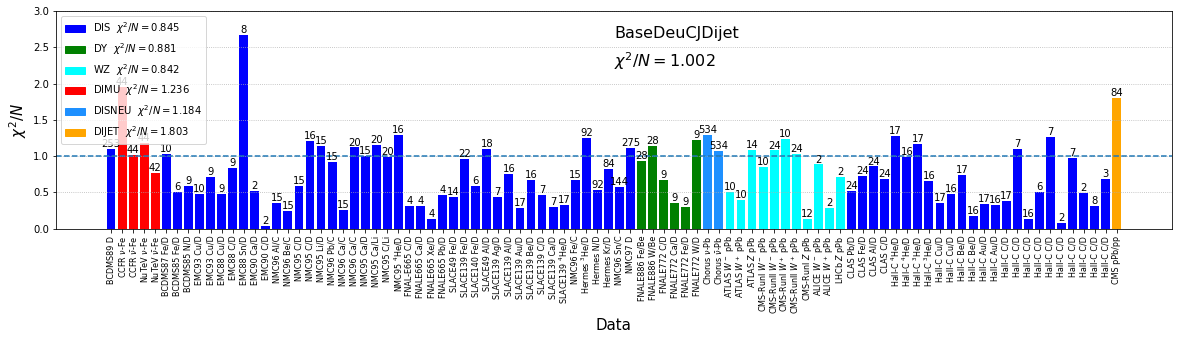

In [10]:



idList = dt.IDlist
idList.sort()
index = np.arange(len(idList))
chi2dof_perid =[]
N_perid = []
colors = []
for id in idList : 
    d = dt.datasets[id] 
    chi2dof_perid.append(d.chi2dof)
    N_perid.append(d.N)
    if id in [791, 792, 793, 794]:
        colors.append("red") #DIMU
    elif id <= 4999 and id >=4000 :
        colors.append("yellow")#SIH
    elif (id <5200 and id >=5000) or (id <=10000  and id>=9900) or id<150 :
        colors.append("blue")#DIS
    elif id <5300 and id >=5200 :
        colors.append("green")#DY
    elif id <5999 and id>=5900 :
        colors.append("dodgerblue")#DISNEU
    elif id>=6000 and id<7000 :
        colors.append("cyan")#WZ
    elif id >=11000 : 
        colors.append("orange") #dijet
    else : 
        pass


idlabel = []
for id in idList : 
    idlabel.append(labelDict[id])

#print(idlabel)
labelColors = ["blue","green", "cyan", "red",  "dodgerblue", "orange"]
#labelColors = ["blue","green", "yellow", "cyan"]
labels = ["DIS  $\chi^2/N = $" +str(round( dt.filterByExp("DIS")[3], 3)),
            "DY  $\chi^2/N = $"+str(round(dt.filterByExp("DY")[3],3)), 
            #"SIH " +str(round(dt.filterByExp("SIH")[3], 3)),
            "WZ  $\chi^2/N = $" +str(round(dt.filterByExp("WZPROD")[3], 3)),
             "DIMU  $\chi^2/N = $" +str(round(dt.filterByExp("DISDIMU")[3], 3)),
             "DISNEU  $\chi^2/N = $"+str(round(dt.filterByExp("DISNEU")[3], 3)),
             "DIJET  $\chi^2/N = $"+str(round(dt.filterByExp("DIJET")[3], 3)),
            ]

        
handles = [plt.Rectangle((0,0),1,1, color=labelColors[i]) for i in range(len(labelColors))]
plt.figure(figsize=(20,4))
fig, ax = plt.subplots(figsize=(20,4))
ax.axhline(1.0, linestyle="dashed")
barPlot = ax.bar(index, chi2dof_perid, color = colors)

for num, rect in zip(N_perid, barPlot):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, num, ha='center', va='bottom',  fontsize=10)
    
# add information on fitname
plt.gca().text(0.5, 0.93, fitname , transform=plt.gca().transAxes, fontsize=16, verticalalignment='top')
# add information on total chi2/dof
plt.gca().text(0.5, 0.82, r"$\chi^2/N={}$".format(round(dt.chi2dof, 3)), transform=plt.gca().transAxes, fontsize=16, verticalalignment='top')
plt.xlabel("Data", fontsize=15)
plt.ylabel('$\chi^2/N$', fontsize=15)
plt.xticks(index, idlabel, fontsize=8, rotation=90)
#plt.title('Chi2/dof per dataset', fontsize=15 )
plt.legend(handles, labels, loc="upper left")
plt.grid(True, axis="y", zorder=0, linestyle="dotted")
plt.ylim(0,3.0)

plt.savefig('chi2dof_'+fitname+'.pdf', bbox_inches='tight')
plt.show()

Chi2 total :  1008.1084016762371
Chi2 w/o penalty :  987.879622892508


<Figure size 1440x288 with 0 Axes>

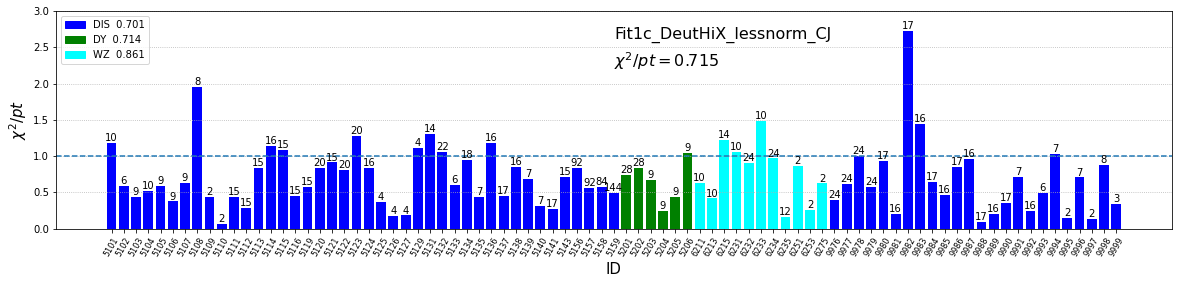

In [37]:
dt = DataSets("Fit1/Fit1c.yaml")
fitname ="Fit1c_DeutHiX_lessnorm_CJ"
idList = dt.IDlist
idList.sort()
index = np.arange(len(idList))
chi2dof_perid =[]
N_perid = []
colors = []
for id in idList : 
    d = dt.datasets[id] 
    chi2dof_perid.append(d.chi2dof)
    N_perid.append(d.N)
    if id in [791, 792, 793, 794]:
        colors.append("red") #DIMU
    elif id <= 4999 and id >=4000 :
        colors.append("yellow")#SIH
    elif (id <5200 and id >=5000) or (id <=10000  and id>=9900) :
        colors.append("blue")#DIS
    elif id <5300 and id >=5200 :
        colors.append("green")#DY
    elif id <5999 and id>=5900 :
        colors.append("dodgerblue")#DISNEU
    elif id>=6000 and id<7000 :
        colors.append("cyan")#WZ
    elif id >=11000 : 
        colors.append("orange") #dijet
    else : 
        pass



labelColors = ["blue","green", "cyan"]
#labelColors = ["blue","green", "yellow", "cyan"]
labels = ["DIS  " +str(round( dt.filterByExp("DIS")[3], 3)),
            "DY  "+str(round(dt.filterByExp("DY")[3],3)), 
            #"SIH " +str(round(dt.filterByExp("SIH")[3], 3)),
            "WZ  " +str(round(dt.filterByExp("WZPROD")[3], 3)),
            ]

        
handles = [plt.Rectangle((0,0),1,1, color=labelColors[i]) for i in range(len(labelColors))]
plt.figure(figsize=(20,4))
fig, ax = plt.subplots(figsize=(20,4))
ax.axhline(1.0, linestyle="dashed")
barPlot = ax.bar(index, chi2dof_perid, color = colors)

for num, rect in zip(N_perid, barPlot):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, num, ha='center', va='bottom',  fontsize=10)
    
# add information on fitname
plt.gca().text(0.5, 0.93, fitname , transform=plt.gca().transAxes, fontsize=16, verticalalignment='top')
# add information on total chi2/dof
plt.gca().text(0.5, 0.82, "$\chi^2/pt={}$".format(round(dt.chi2dof, 3)), transform=plt.gca().transAxes, fontsize=16, verticalalignment='top')
plt.xlabel("ID", fontsize=15)
plt.ylabel('$\chi^2/pt$', fontsize=15)
plt.xticks(index, idList, fontsize=8, rotation=60)
#plt.title('Chi2/dof per dataset', fontsize=15 )
plt.legend(handles, labels, loc="upper left")
plt.grid(True, axis="y", zorder=0, linestyle="dotted")
plt.ylim(0,3.0)

plt.savefig('chi2dof_'+fitname+'.pdf', bbox_inches='tight')
plt.show()

Chi2 total :  1551.981423237215
Chi2 w/o penalty :  1529.0124498082214


<Figure size 1440x288 with 0 Axes>

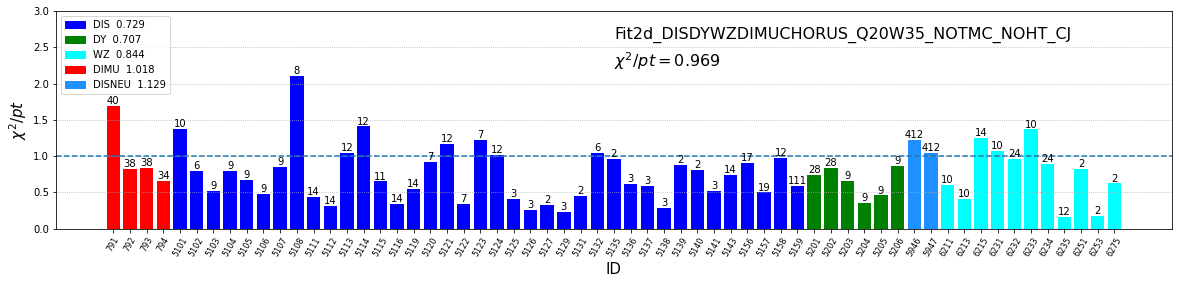

In [42]:
dt = DataSets("Fit2/Fit2d.yaml")
fitname ="Fit2d_DISDYWZDIMUCHORUS_Q20W35_NOTMC_NOHT_CJ"
idList = dt.IDlist
idList.sort()
index = np.arange(len(idList))
chi2dof_perid =[]
N_perid = []
colors = []
for id in idList : 
    d = dt.datasets[id] 
    chi2dof_perid.append(d.chi2dof)
    N_perid.append(d.N)
    if id in [791, 792, 793, 794]:
        colors.append("red") #DIMU
    elif id <= 4999 and id >=4000 :
        colors.append("yellow")#SIH
    elif (id <5200 and id >=5000) or (id <=10000  and id>=9900) :
        colors.append("blue")#DIS
    elif id <5300 and id >=5200 :
        colors.append("green")#DY
    elif id <5999 and id>=5900 :
        colors.append("dodgerblue")#DISNEU
    elif id>=6000 and id<7000 :
        colors.append("cyan")#WZ
    elif id >=11000 : 
        colors.append("orange") #dijet
    else : 
        pass



labelColors = ["blue","green", "cyan", "red",  "dodgerblue"]
#labelColors = ["blue","green", "yellow", "cyan"]
labels = ["DIS  " +str(round( dt.filterByExp("DIS")[3], 3)),
            "DY  "+str(round(dt.filterByExp("DY")[3],3)), 
            #"SIH " +str(round(dt.filterByExp("SIH")[3], 3)),
            "WZ  " +str(round(dt.filterByExp("WZPROD")[3], 3)),
             "DIMU  " +str(round(dt.filterByExp("DISDIMU")[3], 3)),
             "DISNEU  "+str(round(dt.filterByExp("DISNEU")[3], 3)),
            ]

        
handles = [plt.Rectangle((0,0),1,1, color=labelColors[i]) for i in range(len(labelColors))]
plt.figure(figsize=(20,4))
fig, ax = plt.subplots(figsize=(20,4))
ax.axhline(1.0, linestyle="dashed")
barPlot = ax.bar(index, chi2dof_perid, color = colors)

for num, rect in zip(N_perid, barPlot):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, num, ha='center', va='bottom',  fontsize=10)
    
# add information on fitname
plt.gca().text(0.5, 0.93, fitname , transform=plt.gca().transAxes, fontsize=16, verticalalignment='top')
# add information on total chi2/dof
plt.gca().text(0.5, 0.82, "$\chi^2/pt={}$".format(round(dt.chi2dof, 3)), transform=plt.gca().transAxes, fontsize=16, verticalalignment='top')
plt.xlabel("ID", fontsize=15)
plt.ylabel('$\chi^2/pt$', fontsize=15)
plt.xticks(index, idList, fontsize=8, rotation=60)
#plt.title('Chi2/dof per dataset', fontsize=15 )
plt.legend(handles, labels, loc="upper left")
plt.grid(True, axis="y", zorder=0, linestyle="dotted")
plt.ylim(0,3.0)

plt.savefig('chi2dof_'+fitname+'.pdf', bbox_inches='tight')
plt.show()

# Get Chi2 per expeirment table

In [15]:
#pd.set_option('display.max_rows', 100)
dt = DataSets("Fit2/Fit2c.yaml")
display(dt.getChi2Data())

Chi2 total :  2412.9575684274837
Chi2 w/o penalty :  2385.12173126167


,ID,N,Chi2Tot,Chi2/N
0,791,44,85.939027,1.953160
1,792,44,42.685782,0.970131
2,793,44,55.387312,1.258803
3,794,42,31.865233,0.758696
4,5101,10,7.724540,0.772454
5,5102,6,2.817293,0.469549
6,5103,9,6.339128,0.704348
7,5104,10,5.001270,0.500127
8,5105,9,4.691896,0.521322
9,5106,9,3.207103,0.356345


# How to quickly set parameters in the setting file

In [6]:
file = "settings.yaml"
pars = "0.000528447 -0.0772765 0.000586368 0.0722518 0.0560472 -0.00941622 -0.00618822 -0.0247635 0.0202792 -0.0745929 0.515153 -0.0669902 0.434819"
pars = pars.split(" ")
for i, p in enumerate(pars) : 
    p = float(p)
    pars[i] =p


ostream = open(file)
yout = yaml.safe_load(ostream)
yout["Minimizer"]["FitParams"] 
for i, el in enumerate(yout["Minimizer"]["FitParams"] ): 
    if [el[2]!="FIXED"] :
        el[1][0] = pars[i]

yout["Minimizer"]["FitParams"] 

[['c', [0.000528447, 1e-06, 0.0, 0.5], 'BOUNDED'],
 ['uv_a2', [-0.0772765, 0.01], 'FREE'],
 ['uv_b2', [0.000586368, 0.01], 'FREE'],
 ['dv_a2', [0.0722518, 0.01], 'FREE'],
 ['dv_b2', [0.0560472, 0.01], 'FREE'],
 ['uv_a1', [-0.00941622, 0.01], 'FREE'],
 ['uv_b1', [-0.00618822, 0.01], 'FREE'],
 ['dv_a1', [-0.0247635, 0.01], 'FREE'],
 ['dv_b1', [0.0202792, 0.01], 'FREE'],
 ['ubdb_b2', [-0.0745929, 0.01], 'FREE'],
 ['g_a2', [0.515153, 0.01], 'FREE'],
 ['g_b2', [-0.0669902, 0.01], 'FREE'],
 ['ubdb_a2', [0.434819, 0.01], 'FREE']]